# Import Model

In [ ]:
import torch
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1)
        self.bn1   = nn.BatchNorm2d(out_channels)
        self.act1  = nn.SiLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, stride=1, padding=1)
        self.bn2   = nn.BatchNorm2d(out_channels)
        self.shortcut = None
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
        self.act2 = nn.SiLU()

    def forward(self, x):
        identity = x
        out = self.act1(self.bn1(self.conv1(x)))
        out = self.act2(self.bn2(self.conv2(out)))
        if self.shortcut is not None:
            identity = self.shortcut(x)
        return out + identity



class DeepTileEncoder(nn.Module):
    """加深的 Tile 分支：全局信息，多尺度池化 + 三层 MLP"""
    def __init__(self, out_dim, in_channels=3, negative_slope=0.01):
        super().__init__()
        self.layer0 = nn.Sequential(
            nn.Conv2d(in_channels, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.SiLU(),
            nn.MaxPool2d(2)  # 78→39
        )
        self.layer1 = nn.Sequential(
            ResidualBlock(32, 64),
            ResidualBlock(64, 64),
            nn.MaxPool2d(2)  # 39→19
        )
        self.layer2 = nn.Sequential(
            ResidualBlock(64, 128),
            ResidualBlock(128, 128),
            nn.MaxPool2d(2)  # 19→9
        )
        self.layer3 = nn.Sequential(
            ResidualBlock(128, 256),
            ResidualBlock(256, 256)
        )  # 保持 9×9

        # 多尺度池化
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))  # [B,256,1,1]
        self.mid_pool    = nn.AdaptiveAvgPool2d((3, 3))  # [B,256,3,3]

        total_dim = 256*1*1 + 256*3*3
        # 三层 MLP：total_dim → 2*out_dim → out_dim → out_dim
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.1),
            nn.Linear(total_dim, out_dim*4),
            nn.LeakyReLU(negative_slope),
            nn.Dropout(0.1),
            nn.Linear(out_dim*4, out_dim*2),
            nn.LeakyReLU(negative_slope),
            nn.Dropout(0.1),
            nn.Linear(out_dim*2, out_dim),
            nn.LeakyReLU(negative_slope),
        )

    def forward(self, x):
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        # x: [B,256,9,9]
        g = self.global_pool(x).contiguous().reshape(x.size(0), -1)  # [B,256]
        m = self.mid_pool(x).contiguous().reshape(x.size(0), -1)     # [B,256*3*3]

        return self.fc(torch.cat([g, m], dim=1))


class SubtileEncoder(nn.Module):
    """多尺度 Subtile 分支：局部信息 + 两层 MLP"""
    def __init__(self, out_dim, in_channels=3, negative_slope=0.01):
        super().__init__()
        self.layer0 = nn.Sequential(
            nn.Conv2d(in_channels, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.SiLU(),
            nn.MaxPool2d(2)  # 26→13
        )
        self.layer1 = nn.Sequential(
            ResidualBlock(32, 64),
            ResidualBlock(64, 64),
            nn.MaxPool2d(2)  # 13→6
        )
        self.layer2 = nn.Sequential(
            ResidualBlock(64, 128),
            ResidualBlock(128, 128)
        )  # 保持 6×6

        self.global_pool = nn.AdaptiveAvgPool2d((1,1))
        self.mid_pool    = nn.AdaptiveAvgPool2d((2,2))
        self.large_pool    = nn.AdaptiveAvgPool2d((3,3))

        total_dim = 128*1*1 + 128*2*2 + 128*3*3
        # 两层 MLP：total_dim → out_dim*2 → out_dim
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.1),
            nn.Linear(total_dim, out_dim*2),
            nn.LeakyReLU(negative_slope),
            nn.Dropout(0.1),
            nn.Linear(out_dim*2, out_dim),
            nn.LeakyReLU(negative_slope),
        )

    def forward(self, x):
        B, N, C, H, W = x.shape
        x = x.contiguous().reshape(B*N, C, H, W)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        # g,m: [B*N, feat]
        g = self.global_pool(x).contiguous().reshape(B, N, -1)
        m = self.mid_pool(x).contiguous().reshape(B, N, -1)
        l = self.large_pool(x).contiguous().reshape(B, N, -1)

        # 合并 N 张 subtiles，再 FC
        feat = torch.cat([g, m, l], dim=2).mean(dim=1).contiguous()  # [B, total_dim]
        return self.fc(feat)
class CenterSubtileEncoder(nn.Module):
    """專門處理中心 subtile 的 Encoder"""
    def __init__(self, out_dim, in_channels=3, negative_slope= 0.01):
        super().__init__()
        self.layer0 = nn.Sequential(
            nn.Conv2d(in_channels, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.SiLU(),
            nn.MaxPool2d(2)  # 26→13
        )
        self.layer1 = nn.Sequential(
            ResidualBlock(32, 64),
            ResidualBlock(64, 64),
            nn.MaxPool2d(2)  # 13→6
        )
        self.layer2 = nn.Sequential(
            ResidualBlock(64, 128),
            ResidualBlock(128, 128)
        )  # 6×6

        # 多尺度池化
        self.global_pool = nn.AdaptiveAvgPool2d((1,1))
        self.mid_pool    = nn.AdaptiveAvgPool2d((2,2))
        self.large_pool    = nn.AdaptiveAvgPool2d((3,3))

        total_dim = 128*1*1 + 128*2*2 + 128*3*3
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.1),
            nn.Linear(total_dim, out_dim*2),
            nn.LeakyReLU(negative_slope),
            nn.Dropout(0.1),
            nn.Linear(out_dim*2, out_dim),
            nn.LeakyReLU(negative_slope),
        )

    def forward(self, x):
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        g = self.global_pool(x).contiguous().reshape(x.size(0), -1)
        m = self.mid_pool(x).contiguous().reshape(x.size(0), -1)
        l = self.large_pool(x).contiguous().reshape(x.size(0), -1)

        return self.fc(torch.cat([g, m, l], dim=1)).contiguous()



class VisionMLP_MultiTask(nn.Module):
    """整體多任務模型：融合 tile + subtile + center，使用動態權重融合"""
    def __init__(self, tile_dim=128, subtile_dim=64, output_dim=35, negative_slope=0.01):
        super().__init__()
        self.encoder_tile    = DeepTileEncoder(tile_dim)
        self.encoder_subtile = SubtileEncoder(subtile_dim)
        self.encoder_center  = CenterSubtileEncoder(subtile_dim)


        # 輸出 decoder：輸入為 tile_dim (因為融合後只剩一個 vector)
        self.decoder = nn.Sequential(
            nn.Linear(tile_dim + subtile_dim + subtile_dim , 256),
            nn.LeakyReLU(negative_slope),
            nn.Dropout(0.1),
            nn.Linear(256, 128),
            nn.LeakyReLU(negative_slope),
            nn.Dropout(0.1),
            nn.Linear(128, 64),
            nn.LeakyReLU(negative_slope),
            nn.Dropout(0.1),
            nn.Linear(64, output_dim),
        )

    def forward(self, tile, subtiles):
        tile = tile.contiguous()
        subtiles = subtiles.contiguous()
        center = subtiles[:, 4]

        f_tile = self.encoder_tile(tile)         # [B, tile_dim]
        f_sub  = self.encoder_subtile(subtiles)  # [B, subtile_dim]
        f_center = self.encoder_center(center)   # [B, subtile_dim]

        # 拼接三個分支做 gating
        features_cat = torch.cat([f_tile, f_sub, f_center], dim=1)  # [B, tile+sub+center]
        return self.decoder(features_cat)





# 用法示例
model = VisionMLP_MultiTask(tile_dim=128, subtile_dim=128, output_dim=35)


# —— 5) 确保只有 decoder 可训练 ——  
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total     = sum(p.numel() for p in model.parameters())
print(f"Trainable / total params = {trainable:,} / {total:,}")


Trainable / total params = 6,704,678 / 6,704,678


## Load Model

# Import training data

## Same in multiple .pt

In [26]:
import os
import torch

import inspect
from python_scripts.import_data import load_all_tile_data
import numpy as np

# 用法範例
#folder = "dataset/spot-rank/version-3/only_tile_sub/original_train"
folder = "dataset/spot-rank/filtered_directly_rank/masked/realign/Macenko_masked/filtered/train_data/"

grouped_data = load_all_tile_data( 
        folder_path=folder,
        model=model,
        fraction=1,
        shuffle=False
    )

    # grouped_data 現在只會有 model.forward() 需要的 key，
    # 像 ['tile','subtiles','neighbors','norm_coord','node_feat','adj_list','edge_feat','label','source_idx']
print("Loaded keys:", grouped_data.keys())
print("Samples:", len(next(iter(grouped_data.values()))))


Loaded keys: dict_keys(['subtiles', 'label', 'tile', 'source_idx', 'slide_idx'])
Samples: 8348


In [27]:
import os
import torch
import csv
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
from python_scripts.operate_model import train_one_epoch, evaluate, predict, plot_losses, plot_per_cell_metrics,spear_EarlyStopping
import torch.nn as nn

# ---------------------------
# 指定儲存資料夾
# ---------------------------
save_folder = f"/Users/deweywang/Desktop/GitHub/HEVisum/output_folder/rank-spot/realign/no_pretrain/3_encoder/softmax/filtered_directly_rank/k-fold_mix/realign_all/Macenko_masked"  # 修改為你想要的資料夾名稱
if not os.path.exists(save_folder):
    os.makedirs(save_folder)


In [28]:
# --------------------------------------------
# 2) 從 grouped_data 取出 slide_idx，轉成 numpy
# --------------------------------------------
import numpy as np
slide_idx = np.array(grouped_data['slide_idx'])   # shape (N,)

# --------------------------------------------
# 3) 建立 LOGO（或改成 GroupKFold）
# --------------------------------------------
from sklearn.model_selection import LeaveOneGroupOut
logo = LeaveOneGroupOut()

# X 可以給虛擬矩陣，因為分組只靠 groups
X_dummy = np.zeros(len(slide_idx))
X_dummy

array([0., 0., 0., ..., 0., 0., 0.])

EarlyStopping counter: 4/15
[Epoch 43]  lr=1.48e-05, train_loss=31.3839, val_loss=29.6103
train spearman: 0.8374 | Val spearman: 0.8356 | best: 0.8360


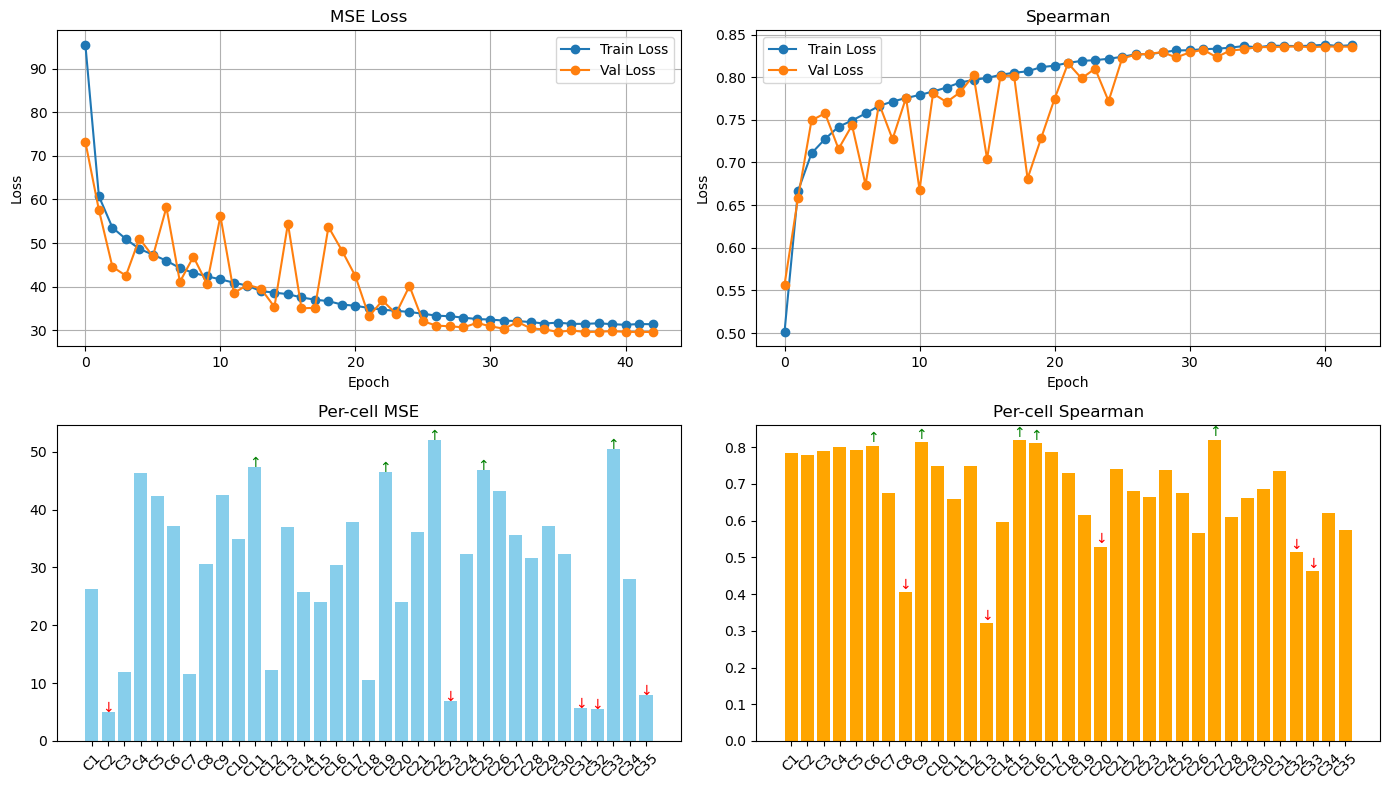

<Figure size 640x480 with 0 Axes>

曲線圖已儲存至 /Users/deweywang/Desktop/GitHub/HEVisum/output_folder/rank-spot/realign/no_pretrain/3_encoder/softmax/filtered_directly_rank/k-fold_mix/realign_all/Macenko_masked/fold0/loss_curve.png


KeyboardInterrupt: 

In [ ]:
from torch.utils.data import DataLoader
from python_scripts.import_data import importDataset
from python_scripts.aug         import augment_grouped_data, identity, subset_grouped_data
import math
from torch.optim.lr_scheduler import LambdaLR
# ---------------- 基本參數 ----------------
start_fold = 0   # 从第几个 fold 开始训练（0-based），小于此值的 fold 会跳过

BATCH_SIZE   = 64
num_epochs   = 100
repeats      = 3
# ---------------- 參數設定 ----------------
save_root    = save_folder          # 最外層
os.makedirs(save_root, exist_ok=True)

# Seed once at the very top for reproducibility

from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
device   = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("✅ device:", device)

overall_best = []
# 在你的脚本文件头部



# 假设 grouped_data['slide_idx'] 是长度为 N 的列表
indices = np.arange(len(grouped_data['slide_idx']))
for fold_id, (tr_idx, va_idx) in enumerate(kf.split(indices)):


    
        # 如果当前 fold < start_fold，就跳过
    if fold_id < start_fold:
        print(f"⏭️ Skipping fold {fold_id}")
        continue
    
    print("Starting fold", fold_id)
    print("Starting subseting...")

    train_base = subset_grouped_data(grouped_data, tr_idx)
    print("Starting augmenting...")

    train_ds = augment_grouped_data(
                    grouped_data=train_base,
                    image_keys=['tile','subtiles'],
                    repeats=repeats   # 比如对每张做 2 次增强
                )
    print("Starting importDataset...")
    # 1) 原始 dataset
    train_ds = importDataset(train_ds, model,
                            image_keys=['tile','subtiles'],
                            transform=identity)


    # 3) validation raw
    val_ds     = subset_grouped_data(grouped_data, va_idx)
    val_ds     = importDataset(val_ds, model,
                            image_keys=['tile','subtiles'],
                            transform=identity)

    print("Starting DataLoader...")
    # 4) DataLoader 不再動態增強
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE,
                              shuffle=True, num_workers=0, pin_memory=False)
    val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE,
                              shuffle=False, num_workers=0, pin_memory=False)

    # 5) 一切其餘步驟同之前：定模型、optimizer、train_one_epoch、evaluate……

    print("Starting model...")
    net = VisionMLP_MultiTask(tile_dim=128, subtile_dim=128, output_dim=35)

    net = net.to(device)

    # 我们把原来 Adam 换成 AdamW，稍微加一点 weight decay
    peak_lr       = 1e-3
    min_lr        = 1e-6
    warmup_epochs = 0
    total_epochs  = 40

    unfreeze_epoch = 0  # 比如在第 50 个 epoch 解冻 encoder

    optimizer = torch.optim.AdamW(
        filter(lambda p: p.requires_grad, net.parameters()),
        lr=peak_lr, weight_decay=1e-3
    )

    # 定义 lr_lambda
    def lr_lambda(cur_epoch):
        if cur_epoch < warmup_epochs:
            # 线性 warm-up: 从 0 → 1
            return float(cur_epoch + 1) / warmup_epochs
        else:
            # 余弦退火：从 1 → min_lr/peak_lr
            progress = (cur_epoch - warmup_epochs) / (total_epochs - warmup_epochs)
            # cos(0)=1 → cos(pi)=−1, remap to [min_ratio,1]
            min_ratio = min_lr / peak_lr
            return min_ratio + 0.5 * (1 - min_ratio) * (1 + math.cos(math.pi * progress))

    scheduler = LambdaLR(optimizer, lr_lambda)

    stopper = spear_EarlyStopping(patience=15)

    # ----- fold 專屬輸出路徑 -----
    fold_dir  = os.path.join(save_folder, f"fold{fold_id}")
    os.makedirs(fold_dir, exist_ok=True)
    best_model_path = os.path.join(fold_dir, "best_model.pt")
    loss_plot_path  = os.path.join(fold_dir, "loss_curve.png")
    csv_path        = os.path.join(fold_dir, "training_log.csv")

    # ----- CSV log -----
    log_f = open(csv_path, "w", newline="")
    csv_w = csv.writer(log_f)
    csv_w.writerow(["Epoch","TrainLoss","ValLoss","ValSpearman","LR"])

    # ----- 圖形 -----
    fig, axes = plt.subplots(2, 2, figsize=(14, 8))
    display(fig)

    train_losses = []; val_losses = []
    train_rhos   = []; val_rhos   = []

    best_rho = -1.0
    print("Starting training...")
    for epoch in range(num_epochs):

        tloss, trho = train_one_epoch(
            net, train_loader, optimizer, device,
            current_epoch=epoch, initial_alpha=0, final_alpha=0, target_epoch=20 )

        vloss, vrho, mse_cell, rho_cell = evaluate(
            net, val_loader, device,
            current_epoch=epoch, initial_alpha=0, final_alpha=0, target_epoch=20 )

        clear_output(wait=True)  # 清除之前的輸出
        axes[0][0].clear()
        axes[0][1].clear()
        axes[1][0].clear()
        axes[1][1].clear()
        # --- save best ---
        if vrho > best_rho:
            best_rho = vrho
            torch.save(net.state_dict(), best_model_path)
            print(f"✅ Saved best model in {best_model_path}!")

        # --- scheduler / early stop ---
        scheduler.step()
        stopper(vrho)


    
        # --- logging ---
        lr = optimizer.param_groups[0]['lr']
        csv_w.writerow([epoch+1, tloss, vloss, vrho, lr])

        train_losses.append(tloss); val_losses.append(vloss)
        train_rhos.append(trho);   val_rhos.append(vrho)
        

        

        # 印出 Epoch 結果
        lr = optimizer.param_groups[0]['lr']
        print(f"[Epoch {epoch+1}]  lr={lr:.2e}, train_loss={tloss:.4f}, val_loss={vloss:.4f}")
        print(f"train spearman: {trho:.4f} | Val spearman: {vrho:.4f} | best: {best_rho:.4f}")
        # --- update plots ---
        plot_losses(train_losses, val_losses, axes[0][0], "MSE Loss")
        plot_losses(train_rhos,   val_rhos,   axes[0][1], "Spearman")
        cell_names = [f"C{i+1}" for i in range(35)]
        plot_per_cell_metrics(mse_cell, rho_cell, cell_names,
                              ax_mse=axes[1][0], ax_spearman=axes[1][1])
        plt.tight_layout(); display(fig); plt.pause(0.1)
        fig.savefig(loss_plot_path)
        print(f"曲線圖已儲存至 {loss_plot_path}")
        if stopper.early_stop:
            print("⛔ early stop"); break

    log_f.close(); plt.close(fig)
    overall_best.append(best_rho) 
    print(f"📈 Fold {fold_id} best ρ = {best_rho:.4f}")

# ========= 整體結果 =========
overall_best = np.array(overall_best)
print("\n=========== CV summary ===========")
for i, r in enumerate(overall_best):
    print(f"fold {i}: best ρ = {r:.4f}")
print(f"overall best (mean) ρ = {overall_best.mean():.4f} ± {overall_best.std():.4f}")

In [17]:

full_dataset = importDataset(grouped_data, model,
                             image_keys=['tile','subtiles'],
                             transform=lambda x: x)

In [2]:
import os
import numpy as np
import joblib
import torch
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.multioutput import MultiOutputRegressor
import lightgbm as lgb
from scipy.stats import rankdata
from python_scripts.import_data import importDataset
from python_scripts.operate_model import predict

full_dataset = importDataset(grouped_data, model,
                             image_keys=['tile','subtiles'],
                             transform=lambda x: x)
# ---------------- Settings ----------------
save_root  = save_folder  # your save_folder path
n_folds    = len([d for d in os.listdir(save_root) if d.startswith('fold')])
n_samples  = len(full_dataset)
C          = 35  # num cell types
start_fold = 0
BATCH_SIZE = 64
# If optimizing Spearman, convert labels to ranks
use_rank   = False

# --- 1) Prepare OOF meta-features ---
# Initialize matrix for OOF predictions
n_samples = len(full_dataset)
oof_preds = np.zeros((n_samples, C), dtype=np.float32)
# True labels (raw or rank)
# importDataset returns a dict-like sample, so label is under key 'label'
y_true = np.vstack([ full_dataset[i]['label'].cpu().numpy() for i in range(n_samples) ])
if use_rank:
    y_meta = np.apply_along_axis(rankdata, 1, y_true)
else:
    y_meta = y_true

# Build CV splitter (must match first stage splits)
logo = LeaveOneGroupOut()

# Loop over folds, load best model, predict on validation indices
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
for fold_id, (tr_idx, va_idx) in enumerate(
        logo.split(X=np.zeros(n_samples), y=None, groups=slide_idx)):
    # Load model
    if fold_id > start_fold:
        print(f"⏭️ Skipping fold {fold_id}")
        continue
    ckpt_path = os.path.join(save_root, f"fold{fold_id}", "best_model.pt")
    print(f"Loading model from {ckpt_path}...")
    net = model.to(device)
    # Alternatively, if your model requires specific args, replace with:
    # net = VisionMLP_MultiTask(tile_dim=64, subtile_dim=64, output_dim=35).to(device)
    net.load_state_dict(torch.load(ckpt_path, map_location=device))
    net.to(device).eval()

    # Predict on validation set
    val_ds = Subset(full_dataset, va_idx)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
    preds = predict(net, val_loader, device)  # (n_val, C)
    oof_preds[va_idx] = preds
    print(f"Fold {fold_id}: OOF preds shape {preds.shape}")

# --- 2) Train LightGBM meta-model ---
# Choose objective: regression on rank (for Spearman) or raw (for MSE)
lgb_base = lgb.LGBMRegressor(
    objective='regression',
    learning_rate=0.001,
    n_estimators=1000,
    num_leaves=31,
    subsample=0.7,
    colsample_bytree=0.7,
    n_jobs=-1,
    force_col_wise=True
)

meta_model = MultiOutputRegressor(lgb_base)
print("Training LightGBM on OOF meta-features...")
meta_model.fit(oof_preds, y_meta)
# Save meta-model
joblib.dump(meta_model, os.path.join(save_root, 'meta_model.pkl'))

# --- 3) Prepare test meta-features ---
n_test = len(test_dataset)
test_meta = np.zeros((n_test, C), dtype=np.float32)
for fold_id in range(n_folds):
    ckpt_path = os.path.join(save_root, f"fold{fold_id}", "best_model.pt")
    net = model.to(device)
    net.load_state_dict(torch.load(ckpt_path, map_location=device))
    net.to(device).eval()
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    preds = predict(net, test_loader, device)
    test_meta += preds
# Average across folds
test_meta /= n_folds

# --- 4) Meta-model predict ---
if use_rank:
    final_preds = meta_model.predict(test_meta) / (C + 1)
else:
    final_preds = meta_model.predict(test_meta)

# --- Save submission ---
import h5py
import pandas as pd
with h5py.File("./dataset/elucidata_ai_challenge_data.h5","r") as f:
    test_spot_ids = pd.DataFrame(np.array(f["spots/Test"]["S_7"]))
sub = pd.DataFrame(final_preds, columns=[f"C{i+1}" for i in range(C)])
sub.insert(0, 'ID', test_spot_ids.index)
sub.to_csv(os.path.join(save_root, 'submission_stacked.csv'), index=False)
print("✅ Saved stacked submission.")


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NameError: name 'grouped_data' is not defined

In [19]:
import os
import numpy as np
import joblib
import torch
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from scipy.stats import rankdata
from python_scripts.import_data import importDataset
from python_scripts.operate_model import predict
from lightgbm import early_stopping, log_evaluation
import h5py
import pandas as pd
# ---------------- Settings ----------------
save_root  = save_folder  # your save_folder path
n_folds    = len([d for d in os.listdir(save_root) if d.startswith('fold')])
n_samples  = len(full_dataset)
C          = 35  # num cell types
start_fold = 0
BATCH_SIZE = 64
# If optimizing Spearman, convert labels to ranks

# --- 1) Prepare OOF meta-features ---
# Initialize matrix for OOF predictions
n_samples = len(full_dataset)
oof_preds = np.zeros((n_samples, C), dtype=np.float32)
# True labels (raw or rank)
# importDataset returns a dict-like sample, so label is under key 'label'
y_true = np.vstack([ full_dataset[i]['label'].cpu().numpy() for i in range(n_samples) ])
y_meta = y_true

# Build CV splitter (must match first stage splits)
logo = LeaveOneGroupOut()
image_latents = np.zeros((n_samples, 128), dtype=np.float32)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 假设 grouped_data['slide_idx'] 是长度为 N 的列表
indices = np.arange(len(grouped_data['slide_idx']))
# Loop over folds, load best model, predict on validation indices
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
for fold_id, (tr_idx, va_idx) in enumerate(kf.split(indices)):

    # Load model
    # if fold_id > start_fold:
    #     print(f"⏭️ Skipping fold {fold_id}")
    #     continue
    ckpt_path = os.path.join(save_root, f"fold{fold_id}", "best_model.pt")
    print(f"Loading model from {ckpt_path}...")
    net = PretrainedEncoderRegressor(
        ae_checkpoint=checkpoint_path,
        ae_type="all",
        center_dim=64, neighbor_dim=64, hidden_dim=128,
        tile_size=26, output_dim=35,
        freeze_encoder = True
    )

    # 2) monkey‐patch 一个新的 head
    net.decoder  = nn.Sequential(
        nn.Linear(64+64, 256),
        nn.SiLU(),
        nn.Dropout(0.1),
        nn.Linear(256, 128),
        nn.SiLU(),
        nn.Dropout(0.1),
        nn.Linear(128, 64),
        nn.SiLU(),
        nn.Dropout(0.1),
        nn.Linear(64, 35)
        
    )
    net = net.to(device)    # Alternatively, if your model requires specific args, replace with:
    # net = VisionMLP_MultiTask(tile_dim=64, subtile_dim=64, output_dim=35).to(device)
    net.load_state_dict(torch.load(ckpt_path, map_location=device))
    net.to(device).eval()
    
    # Predict on validation set
    val_ds = Subset(full_dataset, va_idx)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

    preds = []
    latents = []

    with torch.no_grad():
        for batch in val_loader:
            tiles    = batch['tile'].to(device)
            subtiles = batch['subtiles'].to(device)

            center = subtiles[:, 4].contiguous()
            f_c = net.enc_center(center)
            f_n = net.enc_neigh(subtiles)
            fuse = torch.cat([f_c, f_n], dim=1)

            output = net.decoder(fuse)

            preds.append(output.cpu())
            latents.append(fuse.cpu())  # ⬅️ 收集 latent vector

    preds = torch.cat(preds, dim=0).numpy()    # (n_val, 35)
    latents = torch.cat(latents, dim=0).numpy()  # (n_val, 128)

    oof_preds[va_idx] = preds
    image_latents[va_idx] = latents

    print(f"Fold {fold_id}: OOF preds shape {preds.shape}, Latent shape: {latents.shape}")


    
with h5py.File("dataset/realign/filtered_dataset.h5", "r") as f:
    train_spots = f["spots/Train"]
    
    train_spot_tables = {}
    
    for slide_name in train_spots.keys():
        spot_array = np.array(train_spots[slide_name])
        df = pd.DataFrame(spot_array)
        df["slide_name"] = slide_name
        train_spot_tables[slide_name] = df
        print(f"✅ 已讀取 slide: {slide_name}")

# -----------------------------------------------------
# Step 2: 合併所有 slide 的資料
# -----------------------------------------------------
all_train_spots_df = pd.concat(train_spot_tables.values(), ignore_index=True)
# 提取 x, y
xy = all_train_spots_df[["x", "y"]].to_numpy()  # shape: (8348, 2)

# 合併成新的 meta feature
meta_features = np.concatenate([oof_preds, xy, image_latents], axis=1)
# --- 2) Train LightGBM meta-model ---
# Choose objective: regression on rank (for Spearman) or raw (for MSE)
# 將 meta features 拆成訓練集與 early stopping 用的驗證集
X_train, X_val, y_train, y_val = train_test_split(meta_features, y_meta, test_size=0.2, random_state=42)
print("Meta feature shape:", X_train.shape)
print("Feature std (min/max):", np.min(np.std(X_train, axis=0)), np.max(np.std(X_train, axis=0)))


# # Base model
# lgb_base = lgb.LGBMRegressor(
#     objective='l2',
#     metric='rmse',
#     n_estimators=12000,
#     max_depth=15,
#     learning_rate=0.008,
#     num_leaves=32,
#     colsample_bytree=0.25
# )
lgb_base = lgb.LGBMRegressor(
    objective='l2',
    metric='rmse',
    learning_rate=0.015571848223768656,
    n_estimators=12000,
    max_depth=10,
    num_leaves=178,
    colsample_bytree=0.8587876435508739,
    subsample=0.8,
    subsample_freq=1,
    min_data_in_leaf=32,
    reg_alpha=0.32457648124774724,
    reg_lambda=0.5086328470573691,
    verbosity=-1
)
# 將每個 target 分別 early stopping
meta_model = MultiOutputRegressor(lgb_base)

print("Training LightGBM on OOF meta-features with early stopping...")
meta_model.estimators_ = []

for i in range(y_train.shape[1]):
    print(f"Training target {i}...")
    model  = lgb.LGBMRegressor(
        objective='l2',
        metric='rmse',
        learning_rate=0.015571848223768656,
        n_estimators=12000,
        max_depth=10,
        num_leaves=178,
        colsample_bytree=0.8587876435508739,
        subsample=0.8,
        subsample_freq=1,
        min_data_in_leaf=32,
        reg_alpha=0.32457648124774724,
        reg_lambda=0.5086328470573691,
        verbosity=-1
    )

    model.fit(
        X_train,
        y_train[:, i],
        eval_set=[(X_val, y_val[:, i])],
        callbacks=[
            early_stopping(stopping_rounds=200),
            log_evaluation(period=100)
        ]
    )

    meta_model.estimators_.append(model)

# 保存模型
joblib.dump(meta_model, os.path.join(save_root, 'meta_model.pkl'))


# --- 3) Prepare test meta-features ---
n_test = len(test_dataset)
test_preds = []
test_latents = []

for fold_id in range(n_folds):
    ckpt_path = os.path.join(save_root, f"fold{fold_id}", "best_model.pt")
    net = PretrainedEncoderRegressor(
        ae_checkpoint=checkpoint_path,
        ae_type="center",
        center_dim=64, neighbor_dim=64, hidden_dim=128,
        tile_size=26, output_dim=35,
        freeze_encoder = True
    )

    net.decoder = nn.Sequential(
        nn.Linear(64+64, 256),
        nn.SiLU(),
        nn.Dropout(0.1),
        nn.Linear(256, 128),
        nn.SiLU(),
        nn.Dropout(0.1),
        nn.Linear(128, 64),
        nn.SiLU(),
        nn.Dropout(0.1),
        nn.Linear(64, 35)
    )

    net = net.to(device)
    net.load_state_dict(torch.load(ckpt_path, map_location=device))
    net.eval()

    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    preds = []
    latents = []

    with torch.no_grad():
        for batch in test_loader:
            tiles = batch['tile'].to(device)
            subtiles = batch['subtiles'].to(device)

            center = subtiles[:, 4].contiguous()
            f_c = net.enc_center(center)
            f_n = net.enc_neigh(subtiles)
            fuse = torch.cat([f_c, f_n], dim=1)

            out = net.decoder(fuse)

            preds.append(out.cpu())
            latents.append(fuse.cpu())  # image embedding (128D)

    test_preds.append(torch.cat(preds, dim=0).numpy())      # shape: (n_test, 35)
    test_latents.append(torch.cat(latents, dim=0).numpy())  # shape: (n_test, 128)

# === Stack + Average ===
test_preds = np.mean(np.stack(test_preds, axis=0), axis=0)      # (n_test, 35)
test_latents = np.mean(np.stack(test_latents, axis=0), axis=0)  # (n_test, 128)

with h5py.File("dataset/elucidata_ai_challenge_data.h5", "r") as f:
    test_spots = f["spots/Test"]
    spot_array = np.array(test_spots['S_7'])
    df = pd.DataFrame(spot_array)

xy = df[["x", "y"]].to_numpy()  # shape: (n_test, 2)

# 合併為最終 test meta features
test_meta = np.concatenate([test_preds, xy, test_latents], axis=1)  # shape: (n_test, 35+2+128)



final_preds = meta_model.predict(test_meta)

# --- Save submission ---
import h5py
import pandas as pd
with h5py.File("./dataset/elucidata_ai_challenge_data.h5","r") as f:
    test_spot_ids = pd.DataFrame(np.array(f["spots/Test"]["S_7"]))
sub = pd.DataFrame(final_preds, columns=[f"C{i+1}" for i in range(C)])
sub.insert(0, 'ID', test_spot_ids.index)
sub.to_csv(os.path.join(save_root, 'submission_stacked.csv'), index=False)
print("✅ Saved stacked submission.")


Loading model from /Users/deweywang/Desktop/GitHub/HEVisum/output_folder/rank-spot/realign/pretrain/AE_Center_noaug/filtered_directly_rank/k-fold_mix/realign_all/Macenko_masked/fold0/best_model.pt...


/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_1022/85480835.py:75: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(ckpt_path, map_l

Fold 0: OOF preds shape (1670, 35), Latent shape: (1670, 128)
Loading model from /Users/deweywang/Desktop/GitHub/HEVisum/output_folder/rank-spot/realign/pretrain/AE_Center_noaug/filtered_directly_rank/k-fold_mix/realign_all/Macenko_masked/fold1/best_model.pt...
Fold 1: OOF preds shape (1670, 35), Latent shape: (1670, 128)
Loading model from /Users/deweywang/Desktop/GitHub/HEVisum/output_folder/rank-spot/realign/pretrain/AE_Center_noaug/filtered_directly_rank/k-fold_mix/realign_all/Macenko_masked/fold2/best_model.pt...
Fold 2: OOF preds shape (1670, 35), Latent shape: (1670, 128)
Loading model from /Users/deweywang/Desktop/GitHub/HEVisum/output_folder/rank-spot/realign/pretrain/AE_Center_noaug/filtered_directly_rank/k-fold_mix/realign_all/Macenko_masked/fold3/best_model.pt...
Fold 3: OOF preds shape (1669, 35), Latent shape: (1669, 128)
Loading model from /Users/deweywang/Desktop/GitHub/HEVisum/output_folder/rank-spot/realign/pretrain/AE_Center_noaug/filtered_directly_rank/k-fold_mix/re

/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 5.74205
[200]	valid_0's rmse: 5.57597
[300]	valid_0's rmse: 5.54258
[400]	valid_0's rmse: 5.53447
[500]	valid_0's rmse: 5.52994
[600]	valid_0's rmse: 5.53082
Early stopping, best iteration is:
[439]	valid_0's rmse: 5.52653
Training target 1...


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 2.59198
[200]	valid_0's rmse: 2.48421
[300]	valid_0's rmse: 2.44718
[400]	valid_0's rmse: 2.43519
[500]	valid_0's rmse: 2.43223
[600]	valid_0's rmse: 2.43002
[700]	valid_0's rmse: 2.42767
[800]	valid_0's rmse: 2.42496
[900]	valid_0's rmse: 2.4247
[1000]	valid_0's rmse: 2.42432
[1100]	valid_0's rmse: 2.42324
[1200]	valid_0's rmse: 2.42362
[1300]	valid_0's rmse: 2.42367
Early stopping, best iteration is:
[1143]	valid_0's rmse: 2.42268
Training target 2...


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 3.97168
[200]	valid_0's rmse: 3.82435
[300]	valid_0's rmse: 3.80419
[400]	valid_0's rmse: 3.8009
[500]	valid_0's rmse: 3.79484
[600]	valid_0's rmse: 3.79379
[700]	valid_0's rmse: 3.79199
[800]	valid_0's rmse: 3.7959
[900]	valid_0's rmse: 3.79473
Early stopping, best iteration is:
[700]	valid_0's rmse: 3.79199
Training target 3...
Training until validation scores don't improve for 200 rounds


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


[100]	valid_0's rmse: 7.94231
[200]	valid_0's rmse: 7.62253
[300]	valid_0's rmse: 7.55988
[400]	valid_0's rmse: 7.54243
[500]	valid_0's rmse: 7.52937
[600]	valid_0's rmse: 7.53623
[700]	valid_0's rmse: 7.52924
[800]	valid_0's rmse: 7.53137
Early stopping, best iteration is:
[681]	valid_0's rmse: 7.52727
Training target 4...
Training until validation scores don't improve for 200 rounds


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


[100]	valid_0's rmse: 7.2984
[200]	valid_0's rmse: 6.92503
[300]	valid_0's rmse: 6.85641
[400]	valid_0's rmse: 6.84517
[500]	valid_0's rmse: 6.83871
[600]	valid_0's rmse: 6.8305
[700]	valid_0's rmse: 6.82846
[800]	valid_0's rmse: 6.82273
[900]	valid_0's rmse: 6.823
[1000]	valid_0's rmse: 6.82023
[1100]	valid_0's rmse: 6.82025
[1200]	valid_0's rmse: 6.81469
[1300]	valid_0's rmse: 6.81057
[1400]	valid_0's rmse: 6.80742
[1500]	valid_0's rmse: 6.80798
Early stopping, best iteration is:
[1350]	valid_0's rmse: 6.80585
Training target 5...


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 7.39562
[200]	valid_0's rmse: 7.05031
[300]	valid_0's rmse: 6.98073
[400]	valid_0's rmse: 6.96782
[500]	valid_0's rmse: 6.96314
[600]	valid_0's rmse: 6.96061
[700]	valid_0's rmse: 6.95678
[800]	valid_0's rmse: 6.965
Early stopping, best iteration is:
[666]	valid_0's rmse: 6.95586
Training target 6...
Training until validation scores don't improve for 200 rounds


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


[100]	valid_0's rmse: 3.78774
[200]	valid_0's rmse: 3.70592
[300]	valid_0's rmse: 3.68326
[400]	valid_0's rmse: 3.67839
[500]	valid_0's rmse: 3.67693
[600]	valid_0's rmse: 3.67351
[700]	valid_0's rmse: 3.67642
Early stopping, best iteration is:
[597]	valid_0's rmse: 3.67326
Training target 7...
Training until validation scores don't improve for 200 rounds


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


[100]	valid_0's rmse: 5.57086
[200]	valid_0's rmse: 5.54152
[300]	valid_0's rmse: 5.54448
Early stopping, best iteration is:
[196]	valid_0's rmse: 5.54017
Training target 8...
Training until validation scores don't improve for 200 rounds


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


[100]	valid_0's rmse: 8.15006
[200]	valid_0's rmse: 7.67298
[300]	valid_0's rmse: 7.55716
[400]	valid_0's rmse: 7.50974
[500]	valid_0's rmse: 7.48511
[600]	valid_0's rmse: 7.47508
[700]	valid_0's rmse: 7.46888
[800]	valid_0's rmse: 7.46685
[900]	valid_0's rmse: 7.46518
[1000]	valid_0's rmse: 7.45932
[1100]	valid_0's rmse: 7.45655
[1200]	valid_0's rmse: 7.4526
[1300]	valid_0's rmse: 7.44973
[1400]	valid_0's rmse: 7.44948
[1500]	valid_0's rmse: 7.44909
[1600]	valid_0's rmse: 7.44763
[1700]	valid_0's rmse: 7.44502
[1800]	valid_0's rmse: 7.44217
[1900]	valid_0's rmse: 7.44096
[2000]	valid_0's rmse: 7.4401
[2100]	valid_0's rmse: 7.44079
[2200]	valid_0's rmse: 7.43978
[2300]	valid_0's rmse: 7.44044
Early stopping, best iteration is:
[2195]	valid_0's rmse: 7.4396
Training target 9...


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 6.70593
[200]	valid_0's rmse: 6.34053
[300]	valid_0's rmse: 6.23959
[400]	valid_0's rmse: 6.20537
[500]	valid_0's rmse: 6.1885
[600]	valid_0's rmse: 6.18033
[700]	valid_0's rmse: 6.17452
[800]	valid_0's rmse: 6.17174
[900]	valid_0's rmse: 6.17164
[1000]	valid_0's rmse: 6.17242
[1100]	valid_0's rmse: 6.16992
[1200]	valid_0's rmse: 6.16883
[1300]	valid_0's rmse: 6.16982
[1400]	valid_0's rmse: 6.16713
[1500]	valid_0's rmse: 6.16737
[1600]	valid_0's rmse: 6.16842
Early stopping, best iteration is:
[1408]	valid_0's rmse: 6.16692
Training target 10...
Training until validation scores don't improve for 200 rounds


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


[100]	valid_0's rmse: 7.26945
[200]	valid_0's rmse: 7.03294
[300]	valid_0's rmse: 6.99216
[400]	valid_0's rmse: 6.98543
[500]	valid_0's rmse: 6.98862
[600]	valid_0's rmse: 6.99721
Early stopping, best iteration is:
[446]	valid_0's rmse: 6.98125
Training target 11...
Training until validation scores don't improve for 200 rounds


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


[100]	valid_0's rmse: 3.99634
[200]	valid_0's rmse: 3.75845
[300]	valid_0's rmse: 3.71194
[400]	valid_0's rmse: 3.70027
[500]	valid_0's rmse: 3.69803
[600]	valid_0's rmse: 3.69538
[700]	valid_0's rmse: 3.69594
[800]	valid_0's rmse: 3.69691
Early stopping, best iteration is:
[611]	valid_0's rmse: 3.69469
Training target 12...
Training until validation scores don't improve for 200 rounds


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


[100]	valid_0's rmse: 6.11022
[200]	valid_0's rmse: 6.11283
[300]	valid_0's rmse: 6.12424
Early stopping, best iteration is:
[124]	valid_0's rmse: 6.10109
Training target 13...
Training until validation scores don't improve for 200 rounds


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


[100]	valid_0's rmse: 5.23145
[200]	valid_0's rmse: 5.15171
[300]	valid_0's rmse: 5.15106
[400]	valid_0's rmse: 5.15859
Early stopping, best iteration is:
[258]	valid_0's rmse: 5.1471
Training target 14...
Training until validation scores don't improve for 200 rounds


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


[100]	valid_0's rmse: 5.94756
[200]	valid_0's rmse: 5.63922
[300]	valid_0's rmse: 5.57474
[400]	valid_0's rmse: 5.55917
[500]	valid_0's rmse: 5.55141
[600]	valid_0's rmse: 5.54814
[700]	valid_0's rmse: 5.55413
[800]	valid_0's rmse: 5.55564
Early stopping, best iteration is:
[621]	valid_0's rmse: 5.54754
Training target 15...
Training until validation scores don't improve for 200 rounds


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


[100]	valid_0's rmse: 5.91322
[200]	valid_0's rmse: 5.69182
[300]	valid_0's rmse: 5.65351
[400]	valid_0's rmse: 5.64341
[500]	valid_0's rmse: 5.63669
[600]	valid_0's rmse: 5.63518
[700]	valid_0's rmse: 5.63914
Early stopping, best iteration is:
[521]	valid_0's rmse: 5.63194
Training target 16...
Training until validation scores don't improve for 200 rounds


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


[100]	valid_0's rmse: 6.80371
[200]	valid_0's rmse: 6.50166
[300]	valid_0's rmse: 6.43359
[400]	valid_0's rmse: 6.41606
[500]	valid_0's rmse: 6.41649
[600]	valid_0's rmse: 6.4127
[700]	valid_0's rmse: 6.40782
[800]	valid_0's rmse: 6.41096
[900]	valid_0's rmse: 6.41227
Early stopping, best iteration is:
[702]	valid_0's rmse: 6.40726
Training target 17...
Training until validation scores don't improve for 200 rounds


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


[100]	valid_0's rmse: 3.75485
[200]	valid_0's rmse: 3.58154
[300]	valid_0's rmse: 3.55995
[400]	valid_0's rmse: 3.55958
[500]	valid_0's rmse: 3.56211
Early stopping, best iteration is:
[321]	valid_0's rmse: 3.55562
Training target 18...
Training until validation scores don't improve for 200 rounds


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


[100]	valid_0's rmse: 7.30485
[200]	valid_0's rmse: 7.21934
[300]	valid_0's rmse: 7.21862
[400]	valid_0's rmse: 7.23489
Early stopping, best iteration is:
[221]	valid_0's rmse: 7.20458
Training target 19...
Training until validation scores don't improve for 200 rounds


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


[100]	valid_0's rmse: 5.10512
[200]	valid_0's rmse: 5.03245
[300]	valid_0's rmse: 5.02565
[400]	valid_0's rmse: 5.02203
[500]	valid_0's rmse: 5.01885
[600]	valid_0's rmse: 5.01204
[700]	valid_0's rmse: 5.01157
[800]	valid_0's rmse: 5.01167
[900]	valid_0's rmse: 5.00823
[1000]	valid_0's rmse: 5.00736
[1100]	valid_0's rmse: 5.00668
[1200]	valid_0's rmse: 5.00607
[1300]	valid_0's rmse: 5.00758
Early stopping, best iteration is:
[1187]	valid_0's rmse: 5.00551
Training target 20...


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 6.58097
[200]	valid_0's rmse: 6.42695
[300]	valid_0's rmse: 6.40167
[400]	valid_0's rmse: 6.39275
[500]	valid_0's rmse: 6.38197
[600]	valid_0's rmse: 6.3804
[700]	valid_0's rmse: 6.37364
[800]	valid_0's rmse: 6.37404
Early stopping, best iteration is:
[671]	valid_0's rmse: 6.37292
Training target 21...
Training until validation scores don't improve for 200 rounds


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


[100]	valid_0's rmse: 7.82997
[200]	valid_0's rmse: 7.71643
[300]	valid_0's rmse: 7.68468
[400]	valid_0's rmse: 7.67323
[500]	valid_0's rmse: 7.6731
[600]	valid_0's rmse: 7.67628
Early stopping, best iteration is:
[486]	valid_0's rmse: 7.66839
Training target 22...
Training until validation scores don't improve for 200 rounds


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


[100]	valid_0's rmse: 2.79927
[200]	valid_0's rmse: 2.7404
[300]	valid_0's rmse: 2.72463
[400]	valid_0's rmse: 2.72006
[500]	valid_0's rmse: 2.72287
Early stopping, best iteration is:
[386]	valid_0's rmse: 2.71927
Training target 23...
Training until validation scores don't improve for 200 rounds


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


[100]	valid_0's rmse: 6.09213
[200]	valid_0's rmse: 5.89307
[300]	valid_0's rmse: 5.86411
[400]	valid_0's rmse: 5.85781
[500]	valid_0's rmse: 5.85238
[600]	valid_0's rmse: 5.85176
[700]	valid_0's rmse: 5.85184
Early stopping, best iteration is:
[551]	valid_0's rmse: 5.84754
Training target 24...
Training until validation scores don't improve for 200 rounds


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


[100]	valid_0's rmse: 7.2075
[200]	valid_0's rmse: 6.91399
[300]	valid_0's rmse: 6.84778
[400]	valid_0's rmse: 6.84778
[500]	valid_0's rmse: 6.84693
[600]	valid_0's rmse: 6.85628
[700]	valid_0's rmse: 6.86505
Early stopping, best iteration is:
[514]	valid_0's rmse: 6.84301
Training target 25...
Training until validation scores don't improve for 200 rounds


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


[100]	valid_0's rmse: 6.82508
[200]	valid_0's rmse: 6.70327
[300]	valid_0's rmse: 6.69594
[400]	valid_0's rmse: 6.71392
Early stopping, best iteration is:
[293]	valid_0's rmse: 6.69341
Training target 26...
Training until validation scores don't improve for 200 rounds


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


[100]	valid_0's rmse: 7.66885
[200]	valid_0's rmse: 7.18179
[300]	valid_0's rmse: 7.08492
[400]	valid_0's rmse: 7.07033
[500]	valid_0's rmse: 7.07367
Early stopping, best iteration is:
[362]	valid_0's rmse: 7.06647
Training target 27...
Training until validation scores don't improve for 200 rounds


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


[100]	valid_0's rmse: 6.02144
[200]	valid_0's rmse: 5.90329
[300]	valid_0's rmse: 5.90578
[400]	valid_0's rmse: 5.91514
Early stopping, best iteration is:
[214]	valid_0's rmse: 5.90057
Training target 28...
Training until validation scores don't improve for 200 rounds


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


[100]	valid_0's rmse: 6.80902
[200]	valid_0's rmse: 6.75097
[300]	valid_0's rmse: 6.75088
Early stopping, best iteration is:
[181]	valid_0's rmse: 6.7424
Training target 29...
Training until validation scores don't improve for 200 rounds


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


[100]	valid_0's rmse: 6.0658
[200]	valid_0's rmse: 5.69874
[300]	valid_0's rmse: 5.68434
[400]	valid_0's rmse: 5.69337
Early stopping, best iteration is:
[252]	valid_0's rmse: 5.68057
Training target 30...
Training until validation scores don't improve for 200 rounds


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


[100]	valid_0's rmse: 2.81643
[200]	valid_0's rmse: 2.69637
[300]	valid_0's rmse: 2.67301
[400]	valid_0's rmse: 2.66563
[500]	valid_0's rmse: 2.66513
[600]	valid_0's rmse: 2.66688
Early stopping, best iteration is:
[493]	valid_0's rmse: 2.66335
Training target 31...
Training until validation scores don't improve for 200 rounds


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


[100]	valid_0's rmse: 2.40531
[200]	valid_0's rmse: 2.37535
[300]	valid_0's rmse: 2.37187
[400]	valid_0's rmse: 2.37124
[500]	valid_0's rmse: 2.36945
[600]	valid_0's rmse: 2.3746
Early stopping, best iteration is:
[447]	valid_0's rmse: 2.36823
Training target 32...
Training until validation scores don't improve for 200 rounds


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


[100]	valid_0's rmse: 7.2763
[200]	valid_0's rmse: 7.22425
[300]	valid_0's rmse: 7.21887
[400]	valid_0's rmse: 7.22889
[500]	valid_0's rmse: 7.23518
Early stopping, best iteration is:
[327]	valid_0's rmse: 7.21786
Training target 33...
Training until validation scores don't improve for 200 rounds


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


[100]	valid_0's rmse: 5.62129
[200]	valid_0's rmse: 5.53594
[300]	valid_0's rmse: 5.53433
[400]	valid_0's rmse: 5.54115
Early stopping, best iteration is:
[269]	valid_0's rmse: 5.5321
Training target 34...
Training until validation scores don't improve for 200 rounds


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


[100]	valid_0's rmse: 2.92224
[200]	valid_0's rmse: 2.86732
[300]	valid_0's rmse: 2.85697
[400]	valid_0's rmse: 2.85991
[500]	valid_0's rmse: 2.86075
Early stopping, best iteration is:
[321]	valid_0's rmse: 2.85489


/Users/deweywang/Desktop/GitHub/HEVisum/python_scripts/pretrain_model.py:228: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ae.load_state_dict(torch.load(ae_checkpoint, map_

✅ Saved stacked submission.


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature na

In [12]:
import os
import numpy as np
import joblib
from scipy.stats import rankdata
import lightgbm as lgb
from sklearn.model_selection import LeaveOneGroupOut
from torch.utils.data import DataLoader, Subset
from python_scripts.import_data import importDataset
from python_scripts.operate_model import predict


# --- 配置 ---
meta_folds = [0,1,2,3,4,5]  # 例如只用 fold0, fold2, fold4
C          = 35       # cell type 数量
BATCH_SIZE = 64

# 1) 导入 full_dataset, slide_idx, test_dataset
full_dataset = importDataset(grouped_data, model,
                             image_keys=['tile','subtiles'],
                             transform=lambda x: x)
n_spots = len(full_dataset)

# 2) 生成 OOF preds & 记录 fold id (同你之前做法)
oof_preds    = np.zeros((n_spots, C), dtype=np.float32)
oof_fold_ids = np.full(n_spots, -1, dtype=int)
logo = LeaveOneGroupOut()
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

for fold_id, (tr_idx, va_idx) in enumerate(
        logo.split(X=np.zeros(n_spots), y=None, groups=slide_idx)):
    if fold_id not in meta_folds:
        continue
    # load CNN model & predict
    ckpt = os.path.join(save_root, f"fold{fold_id}", "best_model.pt")
    net  = model.to(device)
    net.load_state_dict(torch.load(ckpt, map_location=device))
    net.eval()
    loader = DataLoader(Subset(full_dataset, va_idx),
                        batch_size=BATCH_SIZE, shuffle=False)
    preds = predict(net, loader, device)  # (n_val, C)
    oof_preds[va_idx]    = preds
    oof_fold_ids[va_idx] = fold_id

# 真标签矩阵 (n_spots, C)
y_true = np.vstack([ full_dataset[i]['label'].cpu().numpy()
                     for i in range(n_spots) ])

# 3) 筛出 meta_folds 的行
mask       = np.isin(oof_fold_ids, meta_folds)
X_meta     = oof_preds[mask]    # (N_meta, C)
y_meta     = y_true[mask]       # (N_meta, C)
slides_sub = slide_idx[mask]    # (N_meta,)

N_meta = X_meta.shape[0]

docs_feat = X_meta.reshape(-1, 1)   # 变成 (N_meta * 35, 1)

# 对应的真实 abundance，也要 flatten
docs_true = y_meta.reshape(-1,)     # (N_meta * 35,)

# 每个 spot 里对 35 个 abundance 做 ordinal 排，即 relevance label
docs_rel = np.zeros_like(docs_true, dtype=int)
for i in range(X_meta.shape[0]):
    start = i * C
    end   = start + C
    docs_rel[start:end] = rankdata(
        docs_true[start:end],
        method='ordinal'
    ) - 1          # 变成 0‐based

# Flatten 之后的 group：每个 spot 下固定 35 条 doc
train_group = [C] * X_meta.shape[0]  # e.g. [35,35,35, ...] 长度 = N_meta

# ------------------------ 2) 训练一个 LGBMRanker ------------------------
ranker = lgb.LGBMRanker(
    objective='lambdarank',
    metric='ndcg@35',      # 也可以只关注 ndcg@5、@10
    label_gain=list(range(docs_rel.max()+1)),
    learning_rate=1e-3,
    n_estimators=1000,
    num_leaves=31,
    subsample=0.7,
    colsample_bytree=0.7,
    n_jobs=-1
)
ranker.fit(
    docs_feat,   # (N_meta*35, 1)
    docs_rel,    # (N_meta*35,)
    group=train_group
)

# ------------------------ 3) 测试时同样 Flatten + Predict ------------------------
# 5) 准备 test_meta，只平均 meta_folds 中的预测
n_folds = len([d for d in os.listdir(save_root) if d.startswith('fold')])
n_test  = len(test_dataset)
test_meta = np.zeros((n_test, C), dtype=np.float32)

for fold_id in range(n_folds):
    if fold_id not in meta_folds:
        continue
    ckpt_path = os.path.join(save_root, f"fold{fold_id}", "best_model.pt")
    net = model.to(device)
    net.load_state_dict(torch.load(ckpt_path, map_location=device))
    net.eval()

    loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    preds = predict(net, loader, device)
    test_meta += preds

# 平均时除以参与的 folds 数目
test_meta /= len(meta_folds)

docs_test_feat = test_meta.reshape(-1, 1)     # (n_test*35, 1)
test_group     = [C] * test_meta.shape[0]    # [35, 35, ..., 35]

docs_test_score = ranker.predict(docs_test_feat, group=test_group)  # (n_test*35,)

# 把分数 reshape 回 (n_test, 35)
scores = docs_test_score.reshape(test_meta.shape[0], C)  


final_scores = test_meta*scores
# 6) 写入 submission
import pandas as pd, h5py


with h5py.File("./dataset/elucidata_ai_challenge_data.h5","r") as f:
    test_spot_ids = pd.DataFrame(np.array(f["spots/Test"]["S_7"]))

sub = pd.DataFrame(final_scores, columns=[f"C{i+1}" for i in range(C)])
sub.insert(0, 'ID', test_spot_ids.index)
sub.to_csv(os.path.join(save_root, 'submission_LGBMRanker.csv'), index=False)
print("✅ Saved stacked submission.")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001748 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 292180, number of used features: 1


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRanker was fitted with feature names
  warnings.warn(


✅ Saved stacked submission.


# Predict

In [9]:
import torch
import inspect
from python_scripts.operate_model import get_model_inputs

def load_node_feature_data(pt_path: str, model, num_cells: int = 35) -> dict:
    """
    根据 model.forward 的参数自动加载 .pt 里对应的字段，
    并且如果没有 label，就自动创建一个全 0 的 label 张量，
    其尺寸为 (样本数, num_cells)，样本数从第一个有 __len__ 的输入推断。

    参数：
      pt_path:     str，.pt 文件路径
      model:       已实例化的 PyTorch 模型
      num_cells:   int，label 的列数（默认 35）

    返回：
      dict: key 对应模型 forward 中的参数名（不含 self），
            value 是对应的 Tensor/ndarray，
            并额外保证有 'label' 字段。
    """
    # 1) 载入原始数据
    raw = torch.load(pt_path, map_location="cpu")

    # 2) 取模型 forward 入参签名（不含 self）
    sig = inspect.signature(model.forward)
    param_names = [p for p in sig.parameters if p != "self"]

    out = {}
    for name in param_names:
        # a) 直接同名
        if name in raw:
            out[name] = raw[name]
            continue
        # b) 复数形式
        if name + "s" in raw:
            out[name] = raw[name + "s"]
            continue
        # c) 模糊匹配（下划线、复数或前后缀）
        cands = [k for k in raw if name in k or k in name]
        if len(cands) == 1:
            out[name] = raw[cands[0]]
            continue
        raise KeyError(f"无法找到 '{name}' 在 pt 文件中的对应字段，raw keys: {list(raw.keys())}")

    # 3) 用第一个支持 len() 的输入推断样本数
    dataset_size = None
    for v in out.keys():
        if hasattr(out[v], "__len__"):
            dataset_size = len(out[v])
            print(f"⚠️ 从 '{v}' 推断样本数量: {dataset_size}")
            break
    if dataset_size is None:
        raise RuntimeError("无法从任何输入中推断样本数量，请检查 pt 文件内容。")

    # 4) 自动补 label

    out["label"] = torch.zeros((dataset_size, num_cells), dtype=torch.float32)
    return out


image_keys = [ 'tile', 'subtiles']


# 用法示例
from python_scripts.import_data import importDataset
# 假设你的 model 已经定义好并实例化为 `model`
test_dataset = load_node_feature_data("dataset/spot-rank/filtered_directly_rank/masked/test/Macenko/test_dataset.pt", model)
test_dataset = importDataset(
        data_dict=test_dataset,
        model=model,
        image_keys=image_keys,
        transform=lambda x: x,  # identity transform
        print_sig=True
    )



/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_66274/2163754159.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  raw = torch.load(pt_path, map_location="cpu"

⚠️ 从 'tile' 推断样本数量: 2088
Model forward signature: (tile, subtiles)


In [ ]:

test_dataset.check_item(1000, 10)


In [10]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [35]:
import glob
import torch
import numpy as np
import pandas as pd
import os
import h5py
from torch.utils.data import DataLoader

# 讀 test spot index
with h5py.File("./dataset/elucidata_ai_challenge_data.h5","r") as f:
    test_spots     = f["spots/Test"]
    test_spot_table= pd.DataFrame(np.array(test_spots['S_7']))

fold_ckpts = sorted(glob.glob(os.path.join(save_folder, "fold*", "best_model.pt")))
models = []
for ckpt in fold_ckpts:
    net = VisionMLP_MultiTask(tile_dim=128, subtile_dim=128, output_dim=35)
    net = net.to(device)
    net.load_state_dict(torch.load(ckpt, map_location="cpu"))
    net.to(device).eval()
    models.append(net)

all_fold_preds = []
for fold_id, net in enumerate(models):
    # 推論
    with torch.no_grad():
        preds = predict(net, test_loader, device)  # (N_test,35) numpy array

    # 1) 存每一折的原始預測
    df_fold = pd.DataFrame(preds, columns=[f"C{i+1}" for i in range(preds.shape[1])])
    df_fold.insert(0, "ID", test_spot_table.index)
    path_fold = os.path.join(save_folder, f"submission_fold{fold_id}.csv")
    df_fold.to_csv(path_fold, index=False)
    print(f"✅ Saved fold {fold_id} predictions to {path_fold}")

    all_fold_preds.append(preds)

# 2) 做 rank‐average ensemble
all_fold_preds = np.stack(all_fold_preds, axis=0)       # (K, N_test, 35)
ranks          = all_fold_preds.argsort(axis=2).argsort(axis=2).astype(float)
mean_rank      = ranks.mean(axis=0)                    # (N_test,35)

# 3) 存 final ensemble
df_ens = pd.DataFrame(mean_rank, columns=[f"C{i+1}" for i in range(mean_rank.shape[1])])
df_ens.insert(0, "ID", test_spot_table.index)
path_ens = os.path.join(save_folder, "submission_rank_ensemble.csv")
df_ens.to_csv(path_ens, index=False)
print(f"✅ Saved rank‐ensemble submission to {path_ens}")


/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_66274/1901899343.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(ckpt, map_loc

✅ Saved fold 0 predictions to /Users/deweywang/Desktop/GitHub/HEVisum/output_folder/rank-spot/realign/no_pretrain/3_encoder/softmax/filtered_directly_rank/k-fold_mix/realign_all/Macenko_masked/submission_fold0.csv
✅ Saved rank‐ensemble submission to /Users/deweywang/Desktop/GitHub/HEVisum/output_folder/rank-spot/realign/no_pretrain/3_encoder/softmax/filtered_directly_rank/k-fold_mix/realign_all/Macenko_masked/submission_rank_ensemble.csv
